<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Итоги" data-toc-modified-id="Итоги-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Итоги</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit

import time
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.stattools import acf

In [2]:
taxi_df = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0])
taxi_df.sort_index(inplace=True)
taxi_df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
taxi_df.info()
taxi_df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


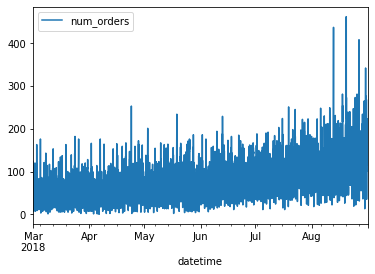

In [4]:
taxi_df = taxi_df.resample('1H').sum()
taxi_df.plot();

In [5]:
# найдем временной промежуток, за который нам предоставли данные
print(taxi_df.index.min())
print(taxi_df.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


## Анализ

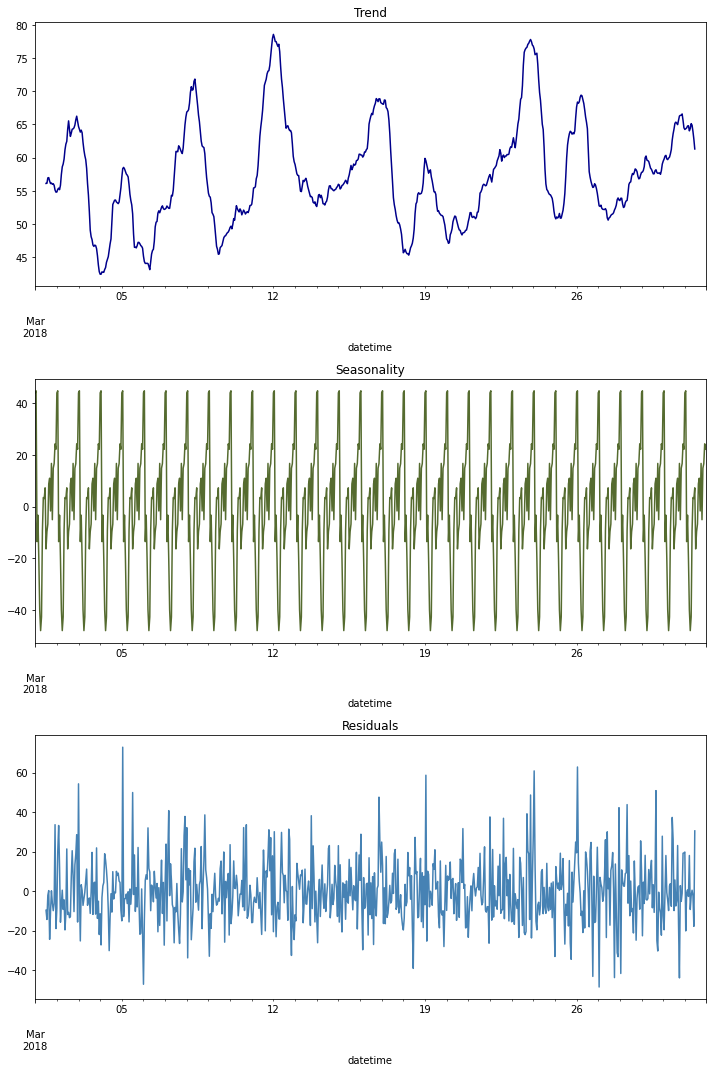

In [6]:
# разложим данные на тренд, сезонность и остаток за месяц

decomposed = seasonal_decompose(taxi_df['2018-03-01':'2018-03-31'])

plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), color='darkblue')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='darkolivegreen')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='steelblue') 
plt.title('Residuals')
plt.tight_layout()

- Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик приходится ближе к вечеру.
- Случайная часть тоже имеет постоянное среднее значение, но периодически возникают большие всплески - вероятно это выходные и праздничные дни, когда спрос на такси повышен.
- Трэнд отражает линейный рост количества заказов со временем.

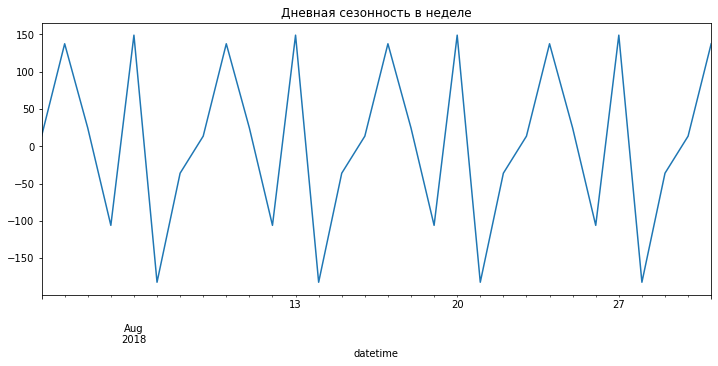

In [7]:
def analysis_plot(data, title):
    data.plot(figsize=(12,5))
    plt.title(title)
df_day = taxi_df.resample('1D').sum()
decomposed_day = seasonal_decompose(df_day)
analysis_plot(decomposed_day.seasonal.tail(30), 'Дневная сезонность в неделе')

In [8]:
#Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    new_df = taxi_df.copy()
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['hour'] = new_df.index.hour
    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = taxi_df['num_orders'].shift(lag)
    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_df
new_df = make_features(taxi_df, 7, 5)
new_df.sample(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-08-20 08:00:00,94,0,8,44.0,47.0,118.0,273.0,224.0,462.0,272.0,141.2
2018-06-17 11:00:00,54,6,11,79.0,62.0,73.0,48.0,18.0,67.0,100.0,56.0
2018-03-11 22:00:00,89,6,22,119.0,99.0,99.0,107.0,78.0,93.0,60.0,100.4
2018-03-11 02:00:00,36,6,2,83.0,81.0,73.0,80.0,62.0,54.0,33.0,75.8
2018-03-27 15:00:00,73,1,15,55.0,24.0,41.0,59.0,84.0,32.0,69.0,52.6
2018-04-02 14:00:00,33,0,14,64.0,57.0,82.0,111.0,57.0,62.0,7.0,74.2
2018-05-21 21:00:00,93,0,21,59.0,90.0,62.0,66.0,122.0,68.0,69.0,79.8
2018-06-02 12:00:00,52,5,12,59.0,85.0,78.0,58.0,26.0,25.0,44.0,61.2
2018-08-27 12:00:00,125,0,12,164.0,170.0,174.0,131.0,37.0,31.0,62.0,135.2


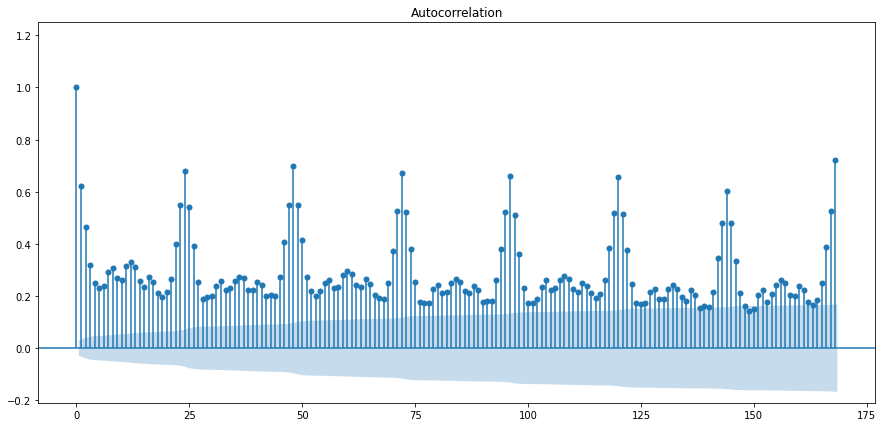

In [9]:
# График автокорреляции
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plot_acf(taxi_df['num_orders'], ax=ax, lags=24*7, auto_ylims=True);

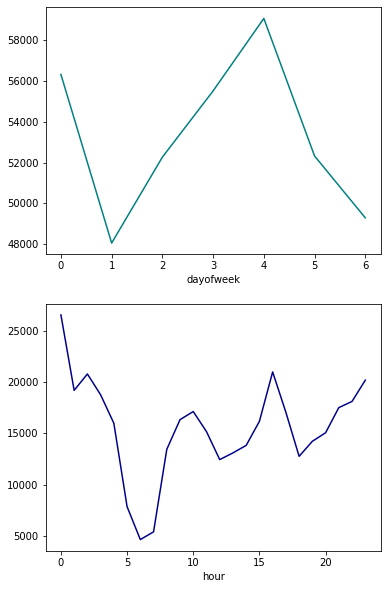

In [10]:
# посмотрим на график количества заказов
plt.figure(figsize=(6,10))
plt.subplot(2,1,1)
new_df.groupby('dayofweek')['num_orders'].sum().plot(color='teal');
plt.subplot(2,1,2)
new_df.groupby('hour')['num_orders'].sum().plot(color='darkblue');

- В разрезе месяцев мы видем линейный рост, к осени количество заказов растет
- По дням недели - пятница самый загруженный день
- Пик заказов по часам - 20:00-24:00

## Обучение

In [11]:
train, test = train_test_split(taxi_df, shuffle=False, test_size=0.1)
#Прогноз модели по прошлом ряду
pred_previous = np.ones(test.shape)*test.shift(fill_value = train.iloc[-1]['num_orders'])
print("RMSE:", np.sqrt(mse(test, pred_previous)))

RMSE: 58.856486242815066


In [12]:
pred_previous.head()

,num_orders
datetime,
2018-08-13 14:00:00,119.0
2018-08-13 15:00:00,102.0
2018-08-13 16:00:00,175.0
2018-08-13 17:00:00,144.0
2018-08-13 18:00:00,152.0


In [13]:
train_1, test_1 = train_test_split(new_df, shuffle=False, test_size=0.1)

In [14]:
train_features = train_1.drop(['num_orders'], axis=1).dropna()
train_target = train_1.iloc[len(train)-len(train_features):]['num_orders']
test_features = test_1.drop(['num_orders'], axis =1)
test_target = test_1['num_orders']

In [15]:
train_features.shape, train_target.shape, test_features.shape, test_target.shape

((3967, 10), (3967,), (442, 10), (442,))

In [18]:
def teach(mod, params):
    if mod == CatBoostRegressor:
        model = CatBoostRegressor(logging_level='Silent')
    else:
        model = mod()
    model.fit(train_features, train_target)
    pred = model.predict(train_features)
    rmse = np.sqrt(mse(train_target, pred))
    print('RMSE base {}: {}'.format(model, '%.2f' % rmse))
    parameters = params
    tscv = TimeSeriesSplit(n_splits = 3)
    grid = GridSearchCV(model, parameters, cv = tscv, scoring = 'neg_mean_squared_error', verbose = False)
    grid.fit(train_features, train_target)
    if mod == CatBoostRegressor:
         model_boosted = mod(**grid.best_params_, logging_level='Silent').fit(train_features, train_target)
    else:
        model_boosted = mod(**grid.best_params_).fit(train_features, train_target)
    boosted_pred = model_boosted.predict(train_features)
    rmse_boosted = np.sqrt(mse(train_target, boosted_pred))
    print()
    print(f'Лучший результат модели: {grid.best_score_}')
    print()
    print("RMSE boosted {}: {}".format(model, '%.2f' % rmse_boosted))
    print()

    return model, model_boosted, rmse, rmse_boosted

In [19]:
%%time
lr_model, lr_model_boosted, lr_rmse, lr_rmse_boosted = teach(LinearRegression, {'fit_intercept':[True,False], 
                                                                            'normalize':[True,False], 
                                                                            'copy_X':[True, False]})

RMSE base LinearRegression(): 31.33

Лучший результат модели: -1156.1311250900615

RMSE boosted LinearRegression(): 31.62

CPU times: user 882 ms, sys: 939 ms, total: 1.82 s
Wall time: 1.81 s


In [20]:
%%time
lgb_model, lgb_model_boosted, lgb_rmse, lgb_rmse_boosted = teach(LGBMRegressor, {"n_estimators": [100, 200],
               "max_depth": [2, 4, 6]
              })

RMSE base LGBMRegressor(): 15.52

Лучший результат модели: -787.2184455698429

RMSE boosted LGBMRegressor(): 18.02

CPU times: user 14.5 s, sys: 27.5 ms, total: 14.5 s
Wall time: 14.4 s


In [21]:
%%time
cat_model, cat_model_boosted, cat_rmse, cat_rmse_boosted = teach(CatBoostRegressor, {'iterations': [1000],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [1, 3]                                                                                
              })

RMSE base <catboost.core.CatBoostRegressor object at 0x7f365108e490>: 14.23

Лучший результат модели: -766.8536266949012

RMSE boosted <catboost.core.CatBoostRegressor object at 0x7f365108e490>: 16.87

CPU times: user 1min 17s, sys: 2.63 s, total: 1min 20s
Wall time: 1min 44s


### Итоги

In [43]:
lr_rmse, lr_rmse_boosted, lgb_rmse, lgb_rmse_boosted, cat_rmse, cat_rmse_boosted

(31.331889183620337,
 53.07895741194868,
 38.66694570860161,
 84.74414402014742,
 14.2283324281051,
 45.39896570808613)

## Тестирование

In [44]:
#RMSE модели с гипермараметрами
final_pred_boost = cat_model_boosted.predict(test_features)
rmse_final = np.sqrt(mse(test_target, final_pred_boost))
print('RMSE {}: {}'.format(cat_model_boosted, '%.2f' % rmse_final))

RMSE <catboost.core.CatBoostRegressor object at 0x7f215f34b910>: 45.40


In [45]:
#RMSE базовой модели
final_pred = cat_model.predict(test_features)
rmse = np.sqrt(mse(test_target, final_pred))
print('RMSE {}: {}'.format(cat_model, '%.2f' % rmse))

RMSE <catboost.core.CatBoostRegressor object at 0x7f215f34b9d0>: 46.22


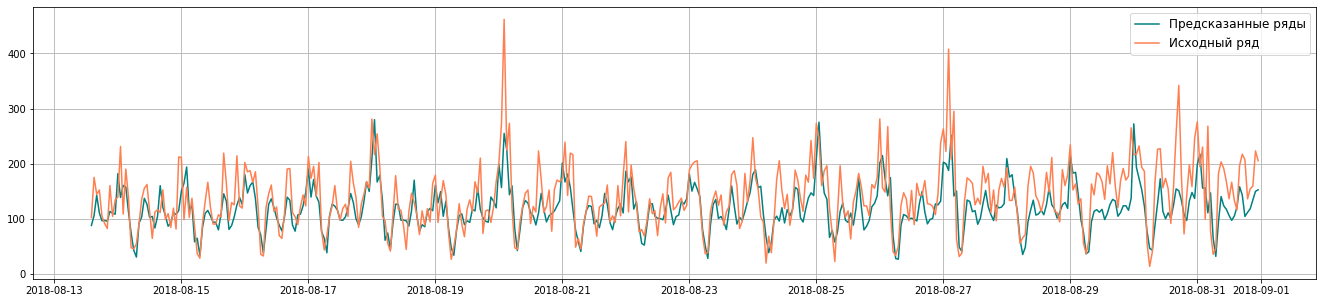

In [54]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(pd.Series(final_pred, index = test_target.index), label='Предсказанные ряды', color = 'teal')
ax.plot(test_target, label='Исходный ряд', color = 'coral')
plt.grid(True)
legend = ax.legend(loc='upper right', fontsize= 12)

## Вывод

Для прогнозирования количества заказов такси на следующий час, мы сделали ресемплирование исходных данных по часу. Создали новые призначи, ввиде дня недели, часа, lag и скользящего среднего. Изучили и визуализировали тренд и сезонность, посмотрели на распределение количества заказов по дням недели и часам.

Для прогнозирования мы использовали следующие модели LinearRegression, LGBMRegressor и CatBoostRegressor:

- Линейная регрессия справилась лучше, чем LGBMRegressor
- Лучше всего снизить RMSE смогла модель CatBoostRegressor
- По графику видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Однако редкие пики в данных предсказать не может.

Можно заключить, что на предсказанный повседневный поток заказов такси можно положится, однако, делать ставку на то, что модель с точностью будет определять нагрузку в праздничные или выходные дни не стоит, т.к. с предсказанием пиковых нагрузок - у нее проблемы.